In [365]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# sklearn
# fuzzywuzzy
# scipy
# arules

In [366]:
data_path = 'survey_results.csv'
data_raw_df= pd.read_csv(data_path)
data_raw_df.head(1)

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [367]:
data_raw_df.shape

(50, 13)

In [368]:
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [369]:
data_raw_df.describe()

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
count,50,50,50,50,49,50,49,50,50,50,50,50,17
unique,4,3,3,3,37,3,23,16,5,3,4,2,17
top,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels,Dashboard,500-1000,Only with professional help,500-1000,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
freq,41,32,36,38,5,37,8,11,19,26,21,33,1


In [370]:
null = pd.DataFrame({'Null Values':data_raw_df.isnull().sum(),'Percentage Null Values':data_raw_df.isnull().sum()*100/len(data_raw_df)})
null

,Null Values,Percentage Null Values
Which age group do you belong to?,0,0.0
What is your gender?,0,0.0
Which category do you currently belong to?,0,0.0
Which of the following best describes you?,0,0.0
Which of these factors are important to you when deciding which car to purchase?,1,2.0
How likely are you to opt for customised vehicle if there were no extra charges?,0,0.0
"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?",1,2.0
"Which of the following interior components would you choose to customise (texture, layout, size, etc)?",0,0.0
How much are you willing to spend on car customisation if surcharges are applicable?,0,0.0
Are you interested in designing your own components to personalise your car?,0,0.0


In [371]:
for column_name in data_raw_df.columns:
    print(column_name)
    print(data_raw_df[column_name].unique())
    print("")

Which age group do you belong to?
['20-30' '51-60' '41-50' '31-40']

What is your gender?
['Male' 'Female' 'Prefer not to say']

Which category do you currently belong to?
['Do not own a car, but planning to purchase in future'
 'Own more than one car' 'Own a car']

Which of the following best describes you?
['Single' 'Married with children' 'Married with no children']

Which of these factors are important to you when deciding which car to purchase?
['Price;Functionality;Size;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Sustainability/environment considerations'
 'Aesthetics;Functionality;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations'
 'Price;Brand name;Aesthetics;Technological features;Functionality'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size'
 'Price;Technological features;Functionality'
 'Price;Br

In [372]:
# Data Cleaning
# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customsied_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "customisation_interest",
                            "How much are you willing to pay for the personalised design? ": "personalised_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [373]:
data_mod_df['3D_design_experience'] = data_mod_df.apply(lambda row: 1 if row['3D_design_experience'] == 'Yes, I can design on my own' else 0, axis=1)

In [374]:
print(data_mod_df['3D_design_experience'].unique())

[0 1]


In [375]:
data_mod_df['purchase_factors'] = data_mod_df['purchase_factors'].str.split(';')
data_mod_df['exterior_components_customisation'] = data_mod_df['exterior_components_customisation'].str.split(';')
data_mod_df['interior_components_customisation'] = data_mod_df['interior_components_customisation'].str.split(';')
data_mod_df.head()

,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],100-500,Only with professional help,500-1000,0,NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Likely,"[Wheels, Grilles, Headlights, Side mirrors]",[Centre compartment],under 500,Only with professional help,under 500,0,wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Aesthetics, Functionality, Customisable options]",Very likely,"[Wheels, Grilles, Headlights, Side mirrors]","[Steering wheel, Dashboard]",500-1000,Yes,500-1000,1,NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Side mirrors, Bu...","[Steering wheel, Centre compartment, Door hand...",under 500,Yes,under 500,0,NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Bumpers]","[Steering wheel, Centre compartment]",over 1000,Only with professional help,over 1000,0,Sg flag/ colour related car paint


In [376]:
purchase_factor_counts = data_mod_df['purchase_factors'].explode().value_counts()
interior_components_counts = data_mod_df['interior_components_customisation'].explode().value_counts()
exterior_components_counts = data_mod_df['exterior_components_customisation'].explode().value_counts()

In [377]:
purchase_factor_counts

purchase_factors
Price                                        44
Functionality                                34
Brand name                                   34
Technological features                       32
Aesthetics                                   31
Size                                         26
Sustainability/environment considerations    17
Customisable options                          9
Name: count, dtype: int64

In [378]:
interior_components_counts


interior_components_customisation
Dashboard                           34
Steering wheel                      28
Centre compartment                  23
Door handles                        15
Sun blocker for front passengers     1
air vent                             1
Name: count, dtype: int64

In [379]:
exterior_components_counts

exterior_components_customisation
Wheels                                                     35
Headlights                                                 27
Grilles                                                    21
Bumpers                                                    16
Side mirrors                                               15
Brakes                                                      1
doors                                                       1
add body kit and change the exhaust and tune the engine     1
Name: count, dtype: int64

In [380]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

In [381]:
# purchase_factors_unique = find_unique_values(data_mod_df, "purchase_factors", ";")
# for factor in purchase_factors_unique:
#   data_mod_df[factor] = data_mod_df["purchase_factors"].str.contains(factor)
# data_mod_df.head(1)


In [382]:
# exterior_components_unique = find_unique_values(data_mod_df, "exterior_components_customisation", ";")
# for components in exterior_components_unique:
#   data_mod_df[components] = data_mod_df["exterior_components_customisation"].str.contains(components)
# data_mod_df.head(1)


In [383]:
# interior_components_unique = find_unique_values(data_mod_df, "interior_components_customisation", ";")
# for components in interior_components_unique:
#   data_mod_df[components] = data_mod_df["interior_components_customisation"].str.contains(components)
# data_mod_df.head(1)


In [384]:
data_mod_df.shape

(50, 13)

In [385]:
# data_mod_df = data_mod_df.drop(columns=["purchase_factors", "exterior_components_customisation", "interior_components_customisation"])

In [386]:
data_mod_df.head(1)

,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],100-500,Only with professional help,500-1000,0,NaN


In [387]:
data_mod_df.shape

(50, 13)

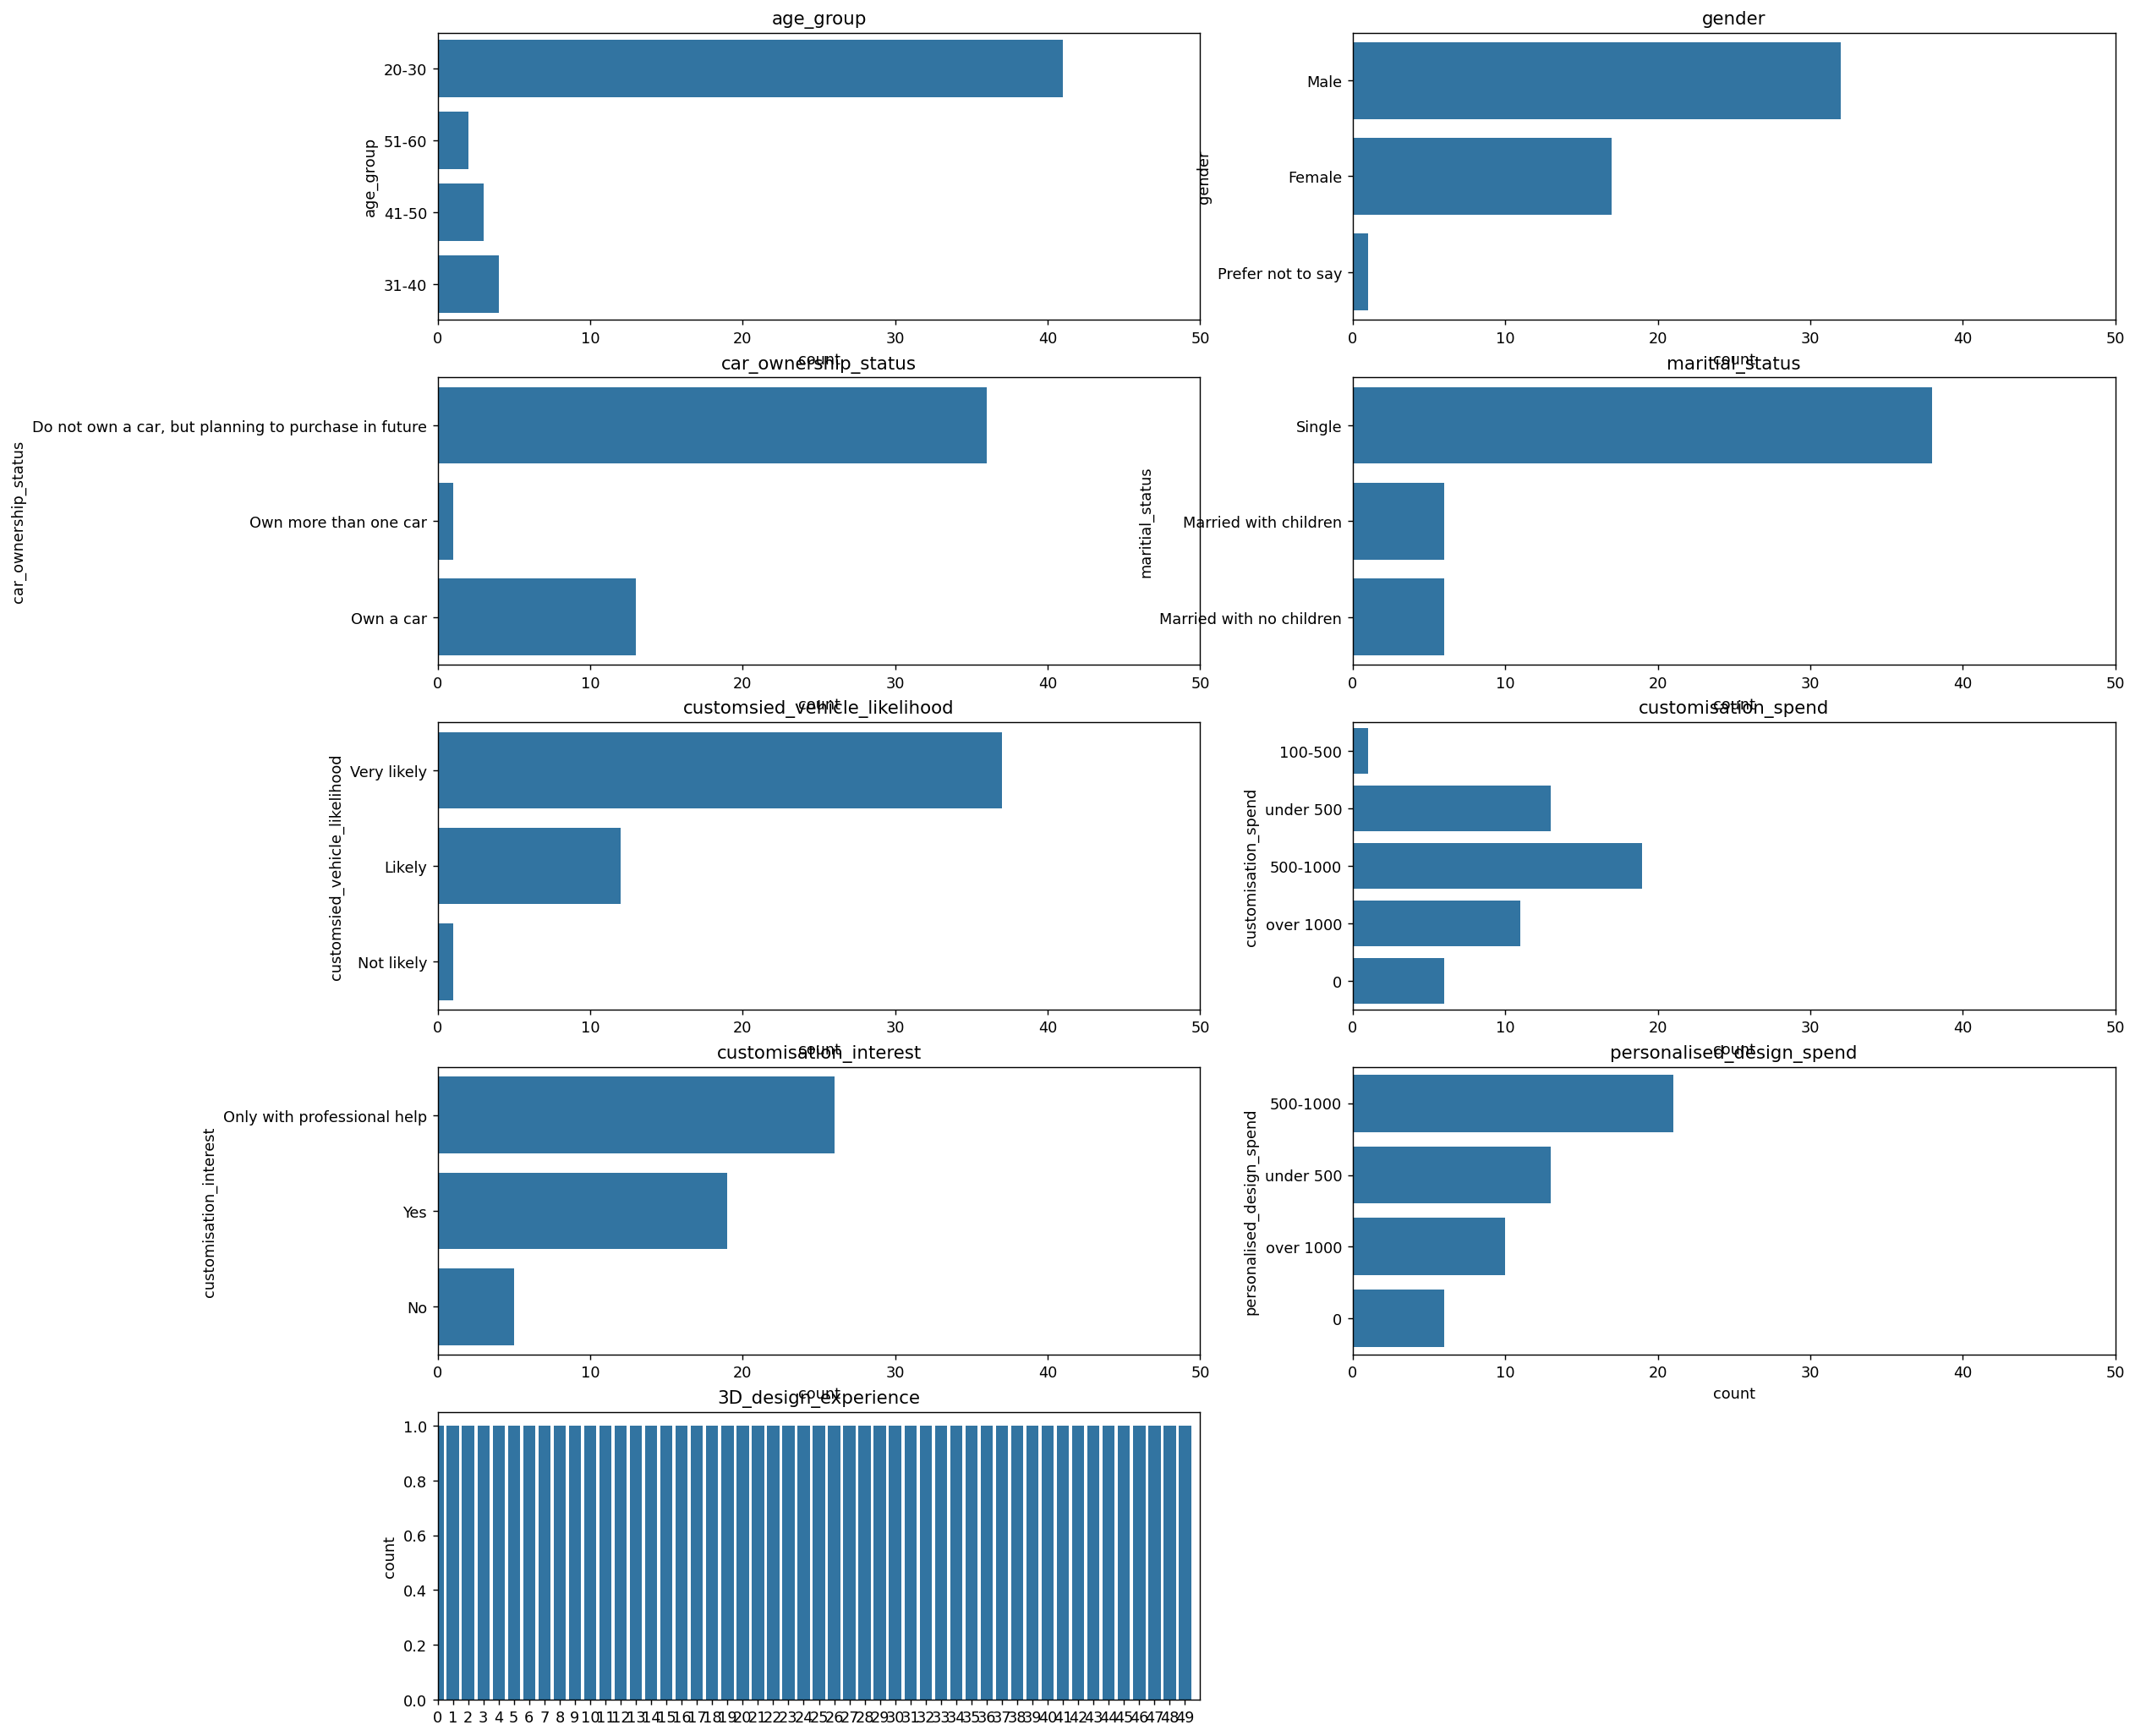

In [392]:
column_names = ['age_group', 
                'gender', 
                'car_ownership_status', 
                'maritial_status', 
                'customsied_vehicle_likelihood', 
                'customisation_spend', 
                'customisation_interest', 
                'personalised_design_spend', 
                '3D_design_experience'
                ]
fig, ax = plt.subplots(dpi = 128, figsize=(20, 20))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data_mod_df[col])
  plt.title(col)
  plt.xlim(0,50)
plt.show()

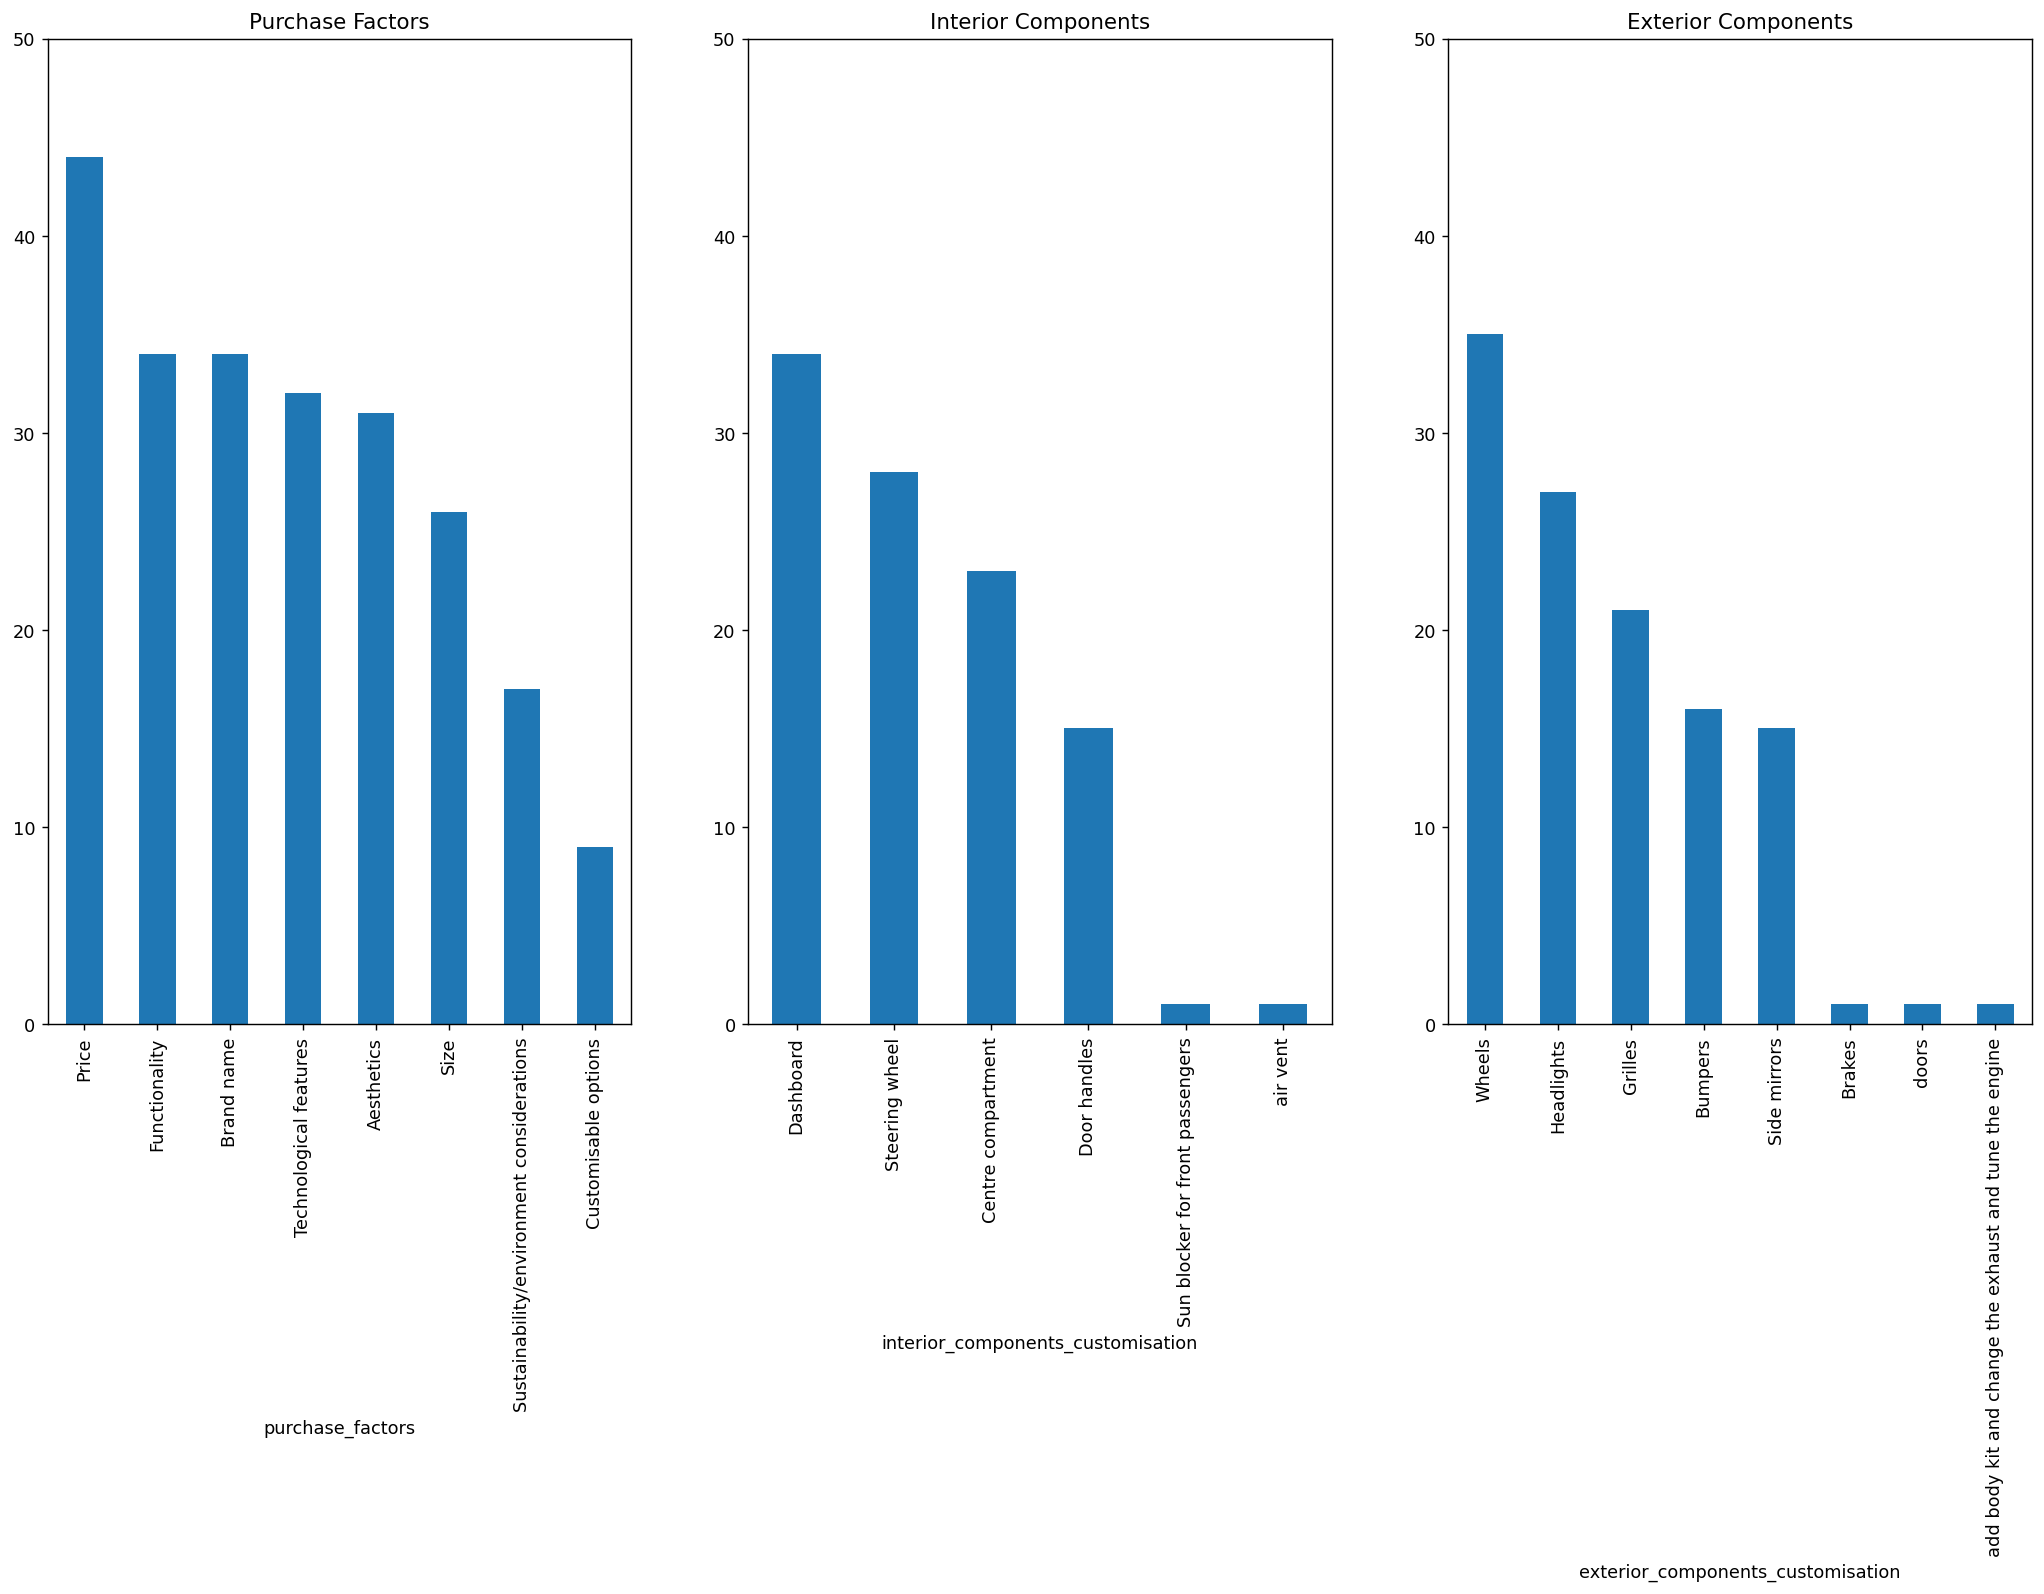

In [400]:
fig, ax = plt.subplots(dpi = 128, figsize=(20, 10))
plt.axis('off')
plt.subplot(1, 3, 1)
plt.title("Purchase Factors")
plt.ylim(0, 50)
purchase_factor_counts.plot(kind='bar')
plt.subplot(1, 3, 2)
plt.title("Interior Components")
plt.ylim(0, 50)
interior_components_counts.plot(kind='bar')
plt.subplot(1, 3, 3)
plt.title("Exterior Components")
plt.ylim(0, 50)
exterior_components_counts.plot(kind='bar')
plt.show()

In [389]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

print(fuzz.ratio("this is a test", "this is sad a test"))


88
